#### Import all the required packages

In [1]:
## basic packages
import numpy as np
import re
import csv
import time
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

##gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

##spacy and nltk
import spacy
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS

##vis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#### load the metadata of podcast transcripts

In [2]:
global df, show_descriptions

meta_data = []
with open("../data/metadata.tsv") as csvfile:
    csvreader = csv.reader(csvfile,delimiter="\t")
    for row in csvreader:
        meta_data.append(row)

df = pd.DataFrame(meta_data[1:],columns=meta_data[0])
show_filename_prefixes = df.show_filename_prefix
episode_filename_prefixes = df.episode_filename_prefix
shows = df.groupby(by=['show_name'])
show_names = shows.apply(lambda x: x.show_name.unique()[0])

In [3]:
genres_topics = ["comedy","news","crime","science","economics","politics","education",\
                  "sports","lifestyle","health","wellbeing","religion","faith","music",\
                  "art","fashion","literature","humanities","drama","fitness","drama",\
                  "fantasy","scifi","gameshow","news quiz","games","game","mental",\
                  "humor","research","technology","society","social","culture","lifestyle",\
                  "songs","cooking","culinary","food","travel","films","film","movies","tv",\
                  "climate","space","planet","digital","artificial intelligence", "ai",\
                  "cars","car","nutrition","wellness","family","history","geography","physics",\
                  "mathematics","math","chemistry","biology","documentary","commentary","nfl",\
                  "mls","nba","mlb","stocks","stock","market","wall","street","wallstreet","business",\
                  "reality","shows","investing","social media","biography","biographies",\
                  "data science","medicine","media","books","book","europe","asia","canada",\
                  "south america","north america","america","usa","netflix","adventure","pets","dogs",\
                  "cats","dog","cat","nintendo","xbox","playstation","ps4","ps5","theatre","mars"\
                  "tennis","australia","conspiracy","war","epidemic","pandemic","climate","change"\
                  "astrology","novel","church","christ","romance","english","kids","astronomy"\
                  "design","entrepreneurship","marketing","digital","christian","christianity","boardgames",\
                  "boardgame","videogames","videogame","twitch","currency","cryptocurrency","federal","bank",\
                  "blockchain","bitcoin","nyse","nft","import","export","capital","money","exchange","boxing",\
                  "mma","wrestling","excercise","excercises","gym","bodybuilding","body-building","yoga",\
                  "stamina","strength","calories","meditation","physical","healthy","pope","bible","catholic",\
                  "catholicism","testament"]

formats = ["monologue","interview","storytelling","repurposed",\
           "bite-sized","co-host conversation","debate","narrative",\
           "scripted","improvised"]

In [4]:
podcasts_genres_topics = {}
for k,show in enumerate(show_names):
    keywords = show.lower().split(" ")
    for word in keywords:
        if word in genres_topics:
            if (k,show) in podcasts_genres_topics:
                if word not in podcasts_genres_topics[(k,show)]:
                    podcasts_genres_topics[(k,show)].append(word)
            else:
                podcasts_genres_topics[(k,show)] = [word]
podcasts = [item[1] for item in podcasts_genres_topics.keys()]

In [5]:
nlp = spacy.load("en_core_web_sm")
stops_nltk = set(stopwords.words("english"))
stops_spacy = STOP_WORDS.union({'ll', 've', 'pron','okay','oh','like','know','yea','yep','yes','no',\
                                "like","oh","yeah","okay","wow","podcast","rating","ratings","not",\
                               "support","anchor","podcasts","episode","http","https","5star","reviews",\
                               "review","instagram","tiktok","amazon","apple","twitter","goole",\
                               "facebook","send","voice message","message","voice","subscribe","follow",\
                               "sponsor","links","easiest","way","fuck","fucking","talk","discuss",\
                               "world","time","want","join","learn","week","things","stuff","find",\
                               "enjoy","welcome","share","talk","talking","people","gmail","help","today",\
                               "listen","best","stories","story","hope","tips","great","journey",\
                               "topics","email","questions","question","going","life","good","friends",\
                               "friend","guys","discussing","live","work","student","students","need",\
                               "hear","think","change","free","better","little","fucking","fuck","shit",\
                                "bitch","sex","easiest","way","currently","follow","follows","needs",\
                               "grow","stay","tuned","walk","understand","tell","tells","ask","helps",\
                                "feel","feels","look","looks","meet","relate","soon","quick","dude","girl",\
                                "girls","guy","literally","spotify","google","totally","played","young",\
                               "begin","began","create","month","year","date","day","terms","lose","list",\
                               "bought","brings","bring","buy","percent","rate","increase","words","value",\
                               "search","awesome","followers","finn","jake","mark","america","american",\
                               "speak","funny","hours","hour","honestly","states","united","franklin",\
                               "patrick","john","build","dave","excited","process","processes","based",\
                                "focus","star","mary","chris","taylor","gotta","liked","hair","adam","chat",\
                               "named","died","born","country","mother","father","children","tools",\
                               "countries","jordan","tommy","listeners","water","jason","lauren","alex",\
                               "laguna","jessica","kristen","examples","example","heidi","stephen","utiful",\
                               "everybody","sorry","came","come","meet","whoa","whoaa","yay","whoaw",\
                               "anybody","somebody","cool","watch","nice","shall"})
stops = stops_nltk.union(stops_spacy)

In [6]:
invest_keywords = ["market","business","invest","stocks","stock","wallstreet","investing",\
                   "investment","exchange","nyse","capital","money","currency","cryptocurrency",\
                   "blockchain","bitcoin","federal","bank","nft"]
invest_category = [(key,val) for key,val in podcasts_genres_topics.items() if ("market" in val)\
                                                            or ("business" in val)\
                                                            or ("invest" in val)\
                                                            or ("stocks" in val)\
                                                            or ("stock" in val)\
                                                            or ("wallstreet" in val)\
                                                            or ("investing" in val)\
                                                            or ("investment" in val)\
                                                            or ("exchange" in val)\
                                                            or ("nyse" in val)\
                                                            or ("capital" in val)\
                                                            or ("money" in val)\
                                                            or ("currency" in val)\
                                                            or ("cryptocurrency" in val)\
                                                            or ("blockchain" in val)\
                                                            or ("bitcoin" in val)\
                                                            or ("federal" in val)\
                                                            or ("bank" in val)\
                                                            or ("nft" in val)]

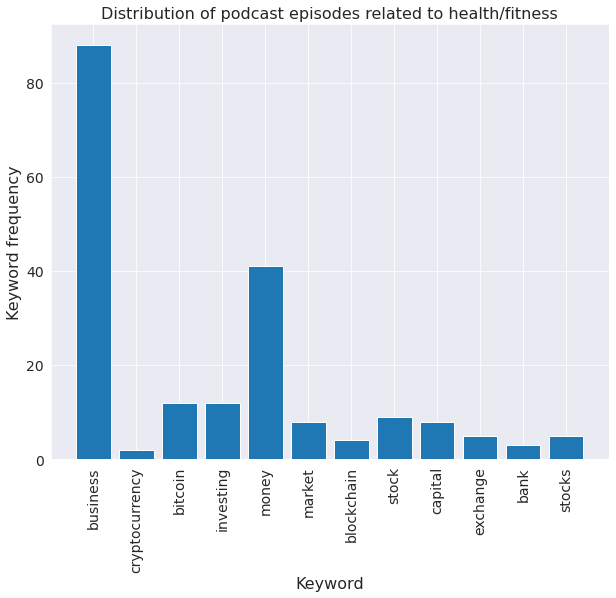

In [7]:
d = {}
for val in podcasts_genres_topics.values():
    for word in invest_keywords:
        if word in val:
            if word in d:
                d[word] += 1
            else:
                d[word] = 1
                
plt.figure(figsize=(10,8))
plt.bar(d.keys(),d.values())
plt.title('Distribution of podcast episodes related to health/fitness',fontsize=16)
plt.xlabel('Keyword',fontsize=16)
plt.ylabel('Keyword frequency',fontsize=16)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14);

In [59]:
number_of_topics = [5,6,7,8,9,10,15]
df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
hyperparams = list(product(number_of_topics,df_parameters))
sports_cs = []
with open('/home1/sgmark/capstone-project/model/coherence_scores_invest_category.csv','r') as f:
    reader = csv.reader(f)
    for row in reader:
        sports_cs.append([float(x) for x in row])
        
best_hp_setting = hyperparams[np.argmax([x[3] for x in sports_cs])]

In [60]:
best_hp_setting

(5, (8, 0.9))

In [43]:
best_hp_setting

(7, (8, 0.8))

In [15]:
best_hp_setting

(5, (2, 0.9))

#### The individual transcript location

In [16]:
def file_location(show,episode):
    search_string = local_path + "/spotify-podcasts-2020" + "/podcasts-transcripts" \
                               + "/" + show[0] \
                               + "/" + show[1] \
                               + "/" + "show_" + show \
                               + "/"
    return search_string

#### load the transcripts

In [17]:
transcripts = {}
for podcast,genre in invest_category:
    for i in shows.get_group(podcast[1])[['show_filename_prefix','episode_filename_prefix']].index:
        show,episode = shows.get_group(podcast[1])[['show_filename_prefix','episode_filename_prefix']].loc[i]
        s = show.split("_")[1]
        try:
            with open('../podcast_transcripts/'+s[0]+'/'+s[1]+'/'+show+'/'+episode+'.txt','r') as f:
                transcripts[(show,episode)] = f.readlines()
            f.close()
        except Exception as e:
            pass
    
keys = list(transcripts.keys())

In [18]:
# Cleaning & remove urls and links
def remove_stops(text,stops):
    final = []
    for word in text:
        if (word not in stops) and (len(word)>3) and (not word.endswith('ing')) and (not word.endswith('ly')):
            final.append(word)
    return final
                       
def clean_text(docs):
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.extend(clean_doc)
    return final

def lemmatization(text_data): 
    nlp = spacy.load("en_core_web_sm")
    texts = []
    for text in text_data:
        doc = nlp(text)
        lem_text = []
        for token in doc:
            if (token.pos_=="VERB") or (token.pos_=="ADV"):
                pass
            else:
                lem_text.append(token.lemma_)
        texts.append(lem_text)
    return texts

# # lemmatization -- do lemmatization for just the verbs
# def get_lemmatized(text):
#     lemmatized = []
#     for phrase in text:
#         sentence=''
#         for word in nlp(phrase):
#             if word.pos_ == "VERB":
#                 #or word.pos_ == "ADJ" or word.pos_ == "ADV":
#                 sentence += ' ' + str(word.lemma_)
#             elif str(word)!='':
#                 sentence += ' ' + str(word)
#         lemmatized.append(sentence.strip())
#     return lemmatized

# def get_named_entities(text):
#     return nlp(text.lower()).ents

# def get_noun_chunks(text):
#     non_stop_noun_chunks = []
#     stops = stopwords.words("english")
#     for word in nlp(text.lower()).noun_chunks:
#         if str(word) not in stops:
#             non_stop_noun_chunks.append(word)
#     return non_stop_noun_chunks

#### tokenize/convert text into words

In [61]:
def normalize_docs(text_data):
    final_texts = []
    for text in text_data:
        new_text = gensim.utils.simple_preprocess(text,deacc=True)
        final_texts.append(new_text)
    return final_texts

In [62]:
docs = []
for text in transcripts.values():
    docs.append(' '.join(clean_text(normalize_docs(text))))

In [63]:
texts = lemmatization(docs)
texts = [remove_stops(text,stops) for text in texts]

### Using bigrams

In [64]:
from gensim.models.phrases import Phrases

bigram = Phrases(texts, min_count=5)

for i in range(len(texts)):
    for token in bigram[texts[i]]:
        if '_' in token:
            texts[i].append(token)

#### Construct a corpus of words as a bag of words 

In [65]:
dictionary = corpora.Dictionary(texts)

dictionary.filter_extremes(no_below=best_hp_setting[1][0],no_above=best_hp_setting[1][1])

In [66]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [24]:
# from itertools import product

# number_of_topics = [5,6,7,8,9,10,15]
# df_parameters = list(product([2,3,4,5,6,7,8,9,10],[0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
# coherence_scores_umass = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_uci = np.zeros((len(number_of_topics),len(df_parameters)))
# coherence_scores_npmi = np.zeros((len(number_of_topics),len(df_parameters)))

# j = 0
# for num in number_of_topics:
#     i = 0
#     for n,m in df_parameters:
#         dictionary = corpora.Dictionary(texts)
#         dictionary.filter_extremes(no_below=n,no_above=m)
#         corpus = [dictionary.doc2bow(text) for text in texts]
#         num_topics = num
#         chunksize = 200
#         passes = 20
#         iterations = 500
#         eval_every = None

#         lda_model = gensim.models.ldamodel.LdaModel(corpus,
#                                                    id2word=dictionary,
#                                                    num_topics=num_topics,
#                                                    chunksize=chunksize,
#                                                    passes=passes,
#                                                    iterations=iterations,
#                                                    alpha='auto',
#                                                    eta='auto',
#                                                    random_state = 123,
#                                                    eval_every=eval_every)
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_uci')
#         coherence_scores_uci[j,i] = cm.get_coherence()
#         cm = CoherenceModel(lda_model, texts=texts,corpus=corpus, coherence= 'c_npmi')
#         coherence_scores_npmi[j,i] = cm.get_coherence() 
#         cm = CoherenceModel(lda_model, corpus=corpus, coherence= 'u_mass')
#         coherence_scores_umass[j,i] = cm.get_coherence()
#         with open("coherence_scores_invest_category.csv",'a') as f:
#             writer = csv.writer(f)
#             writer.writerow([num,n,m,coherence_scores_uci[j,i],coherence_scores_npmi[j,i],\
#                              coherence_scores_umass[j,i]])
#         i += 1
#         print(i)
#     j += 1
#     print(j)

In [67]:
%%time
import logging
logging.basicConfig(filename='invest_topics.log', encoding='utf-8',format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

num_topics = best_hp_setting[0]
chunksize = 200
passes = 50
iterations = 500
eval_every = None

lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           chunksize=chunksize,
                                           passes=passes,
                                           iterations=iterations,
                                           alpha='auto',
                                           eta='auto',
                                           random_state=123,
                                           eval_every=eval_every)

CPU times: user 1min 1s, sys: 46.8 ms, total: 1min 1s
Wall time: 1min 1s


In [50]:
top_topics = lda_model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics])/num_topics

print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -0.8208.


In [68]:
cm = CoherenceModel(lda_model, texts = texts, corpus=corpus, coherence='c_npmi')
coherence = cm.get_coherence() 
print(coherence)
for x in cm.get_coherence_per_topic(): print(x)

0.021034872425582093
0.019321065561495796
0.019005752232047927
0.023639592175367305
0.023296080461370064
0.01991187169762938


### Visualizing data

In [75]:
vis = pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary,mds="mmds",R=20)
pyLDAvis.save_json(vis,'invest_uci.json')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.225229  0.071671       1        1  26.795111
2      0.031997  0.079593       2        1  22.174228
3     -0.161071 -0.083874       3        1  21.167882
0     -0.145653  0.197656       4        1  18.495878
4      0.049498 -0.265047       5        1  11.366902, topic_info=          Term          Freq         Total Category  logprob  loglift
59     bitcoin   6995.000000   6995.000000  Default  20.0000  20.0000
1681     trade   5171.000000   5171.000000  Default  19.0000  19.0000
234      stock   6093.000000   6093.000000  Default  18.0000  18.0000
888     option   4064.000000   4064.000000  Default  17.0000  17.0000
14    business  13114.000000  13114.000000  Default  16.0000  16.0000
...        ...           ...           ...      ...      ...      ...
5     platform    731.873203   2041.758139   Topic5  -5.1251   1.1485
44     account    724.835261   1971.947862   Topic5  -5.1348   1.1736
467   investor    695.812514   2284.315804   Topic5  -5.1756   0.9857
98      dollar    736.871636   5946.813690   Topic5  -5.1183   0.0863
446       high    682.213190   4436.302869   Topic5  -5.1954   0.3022

[281 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
42        1  0.382959     able
42        2  0.246999     able
42        3  0.157428     able
42        4  0.136207     able
42        5  0.076246     able
...     ...       ...      ...
1056      1  0.029022  youtube
1056      2  0.052697  youtube
1056      3  0.120669  youtube
1056      4  0.652226  youtube
1056      5  0.145109  youtube

[565 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1, 5])

In [141]:
# from pprint import pprint
# pprint(top_topics)

In [76]:
# import pickle

# pickle.dump(lda_model,open('../model/invest_episodes_lda_model_uci.pkl','wb'))
# pickle.dump(dictionary,open('../model/invest_episodes_dictionary_uci.pkl','wb'))
# pickle.dump(corpus,open('../model/invest_episodes_corpus_uci.pkl','wb'))
pickle.dump(texts,open('../model/invest_episodes_texts.pkl','wb'))

In [30]:
# import pickle

# file = open('../model/invest_episodes_lda_model.pkl','rb')
# lda_model = pickle.load(file)
# file.close()

# file = open('../model/invest_episodes_corpus.pkl','rb')
# corpus = pickle.load(file)
# file.close()

# file = open('../model/invest_episodes_dictionary.pkl','rb')
# dictionary = pickle.load(file)
# file.close()

In [71]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    podcast_list = []
    episode_list = []
    duration_list = []
    publisher_list = []
    show_prefix_list = []
    episode_prefix_list = []
    descriptions_list = []
    
    for key,wc in zip(keys,bow):
        show_prefix_list.append(key[0])
        episode_prefix_list.append(key[1])
        podcast_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].show_name.iloc[0])
        episode_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_name.iloc[0])
        duration_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].duration.iloc[0])
        publisher_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].publisher.iloc[0])
        descriptions_list.append(df[(df['show_filename_prefix'] == key[0])&(df['episode_filename_prefix'] == key[1])].episode_description.iloc[0])
        
        
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(show_prefix_list, name='show_filename_prefix'),
                           pd.Series(episode_prefix_list, name='episode_filename_prefix'),
                           pd.Series(podcast_list, name='Podcast_name'),
                           pd.Series(episode_list, name='Episode_name'),
                           pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords'),
                           pd.Series(duration_list, name='Duration of the episode'),
                           pd.Series(publisher_list, name='Publisher of the show'),
                           pd.Series(descriptions_list, name='Description of the episode')], axis=1)

    return result_df

In [72]:
main_topic_df = get_main_topic_df(lda_model,corpus,texts)

In [73]:
main_topic_df.to_pickle('invest_main_df_uci.pkl')

In [74]:
main_topic_df.head(5)

,show_filename_prefix,episode_filename_prefix,Podcast_name,Episode_name,Dominant_topic,Percent,Processed_text,Keywords,Duration of the episode,Publisher of the show,Description of the episode
0,show_6S7xPTkVVxfkRcVlgyNSA9,0NVURrFQ7Se20NuZ2uM7Xz,"""Mind"" Your Business With Satyam Tiwari | Pers...",How to grow your following on any social media...,0,0.697,"[discussion, social, medium, platform, wise, a...",business company customer kind mean money prod...,0.9798833333333332,Satyam Tiwari,This episode tells you how you could grow your...
1,show_6S7xPTkVVxfkRcVlgyNSA9,5aohOxM9Fd9DLRAaHWrhMK,"""Mind"" Your Business With Satyam Tiwari | Pers...",Art Of Branding.,0,0.659,"[brand, brand, company, personality, overall, ...",business company customer kind mean money prod...,1.3684333333333334,Satyam Tiwari,This episode tells you about the art of Brandi...
2,show_6S7xPTkVVxfkRcVlgyNSA9,75TyuO5afvpm3Etc8rMxFW,"""Mind"" Your Business With Satyam Tiwari | Pers...","Welcome to ""MIND YOUR BUSINESS""",1,0.572,"[mind, business, host, satyam, tiwari, entrepr...",book business different kind love mean money p...,0.8792666666666666,Satyam Tiwari,"This is my first Podcast ever, I hope to bring..."
3,show_15suW5RwUCtDJfJBQP2juA,2oAhAGOEPbWqXulYkkB8nS,A Bitcoin Micro Pod,LM02: Getbittr with Ruben Waterman,2,0.925,"[english, host, spanish, luna, decoy, second, ...",bitcoin coin game kind mean money point sort s...,15.24545,Lunaticoin,Do you know Getbittr? It's worth doing so beca...
4,show_565aq0KMhlm2bfcel0PE8x,5oJlplKR9SL41JOefobwAe,A Millennial’s Guide to Real Estate Investing ...,"From Bus Boy to $350,000 Monthly Cashflow with...",3,0.534,"[millennial, real, estate, host, antoine, mart...",bull company dollar kind market million money ...,35.77188333333333,Antoine Martel,On this episode I sit down with Bobby Castro a...


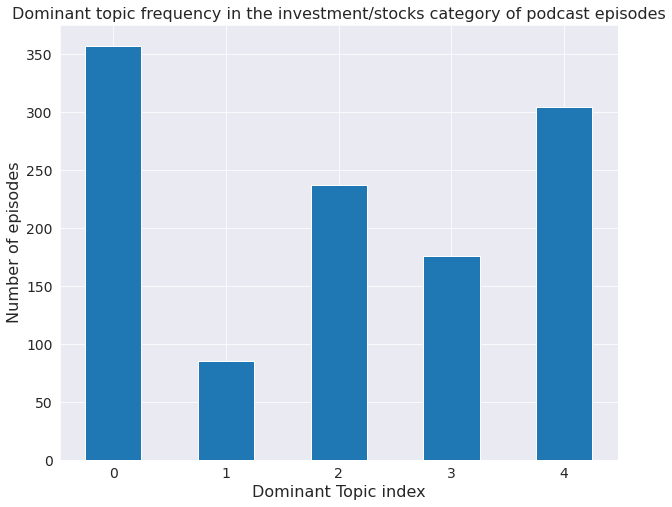

In [35]:
plt.figure(figsize=(10,8))
topics_groups = main_topic_df.groupby('Dominant_topic')
plt.bar(range(best_hp_setting[0]),topics_groups.count()['Podcast_name'],width=0.5)
plt.title('Dominant topic frequency in the investment/stocks category of podcast episodes',fontsize=16)
plt.xlabel('Dominant Topic index',fontsize=16)
plt.ylabel('Number of episodes',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [36]:
representatives = pd.DataFrame()

for k in topics_groups.groups.keys():
    representatives = pd.concat([representatives, 
                                 topics_groups.get_group(k).sort_values(['Percent'], ascending=False).head(1)])
    
for k,words in enumerate(representatives.Keywords):
    print(f'topic {k}: {words}')

topic 0: business customer different important kind love money product tile woman
topic 1: bitcoin block bull coin freak mean network node transaction wallet
topic 2: financial investment market minute money option risk stock trade trader
topic 3: couple different food game kind long love mean point sure
topic 4: bank cash company dollar kind market million money point price


In [71]:
# print('Document: {}  Dominant topic: {}\n'.format(representatives.index[2], 
#                                        representatives.loc[representatives.index[2]]['Dominant_topic']))
# print([sentence.strip() for sentence in transcripts[keys[representatives.index[2]]]])

In [39]:
num_topics = best_hp_setting[0]
def word_count_by_topic(topic=0):
    d_lens = [len(d) for d in topics_groups.get_group(topic)['Processed_text']]
    plt.figure(figsize=(10,8))
    plt.hist(d_lens)
    large = plt.gca().get_ylim()[1]
    d_mean = round(np.mean(d_lens), 1)
    d_median = np.median(d_lens)
    plt.plot([d_mean, d_mean], [0,large], label='Mean = {}'.format(d_mean))
    plt.plot([d_median, d_median], [0,large], label='Median = {}'.format(d_median))
    plt.legend()
    plt.xlabel('Document word count',fontsize=16)
    plt.ylabel('Number of documents',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

In [40]:
from ipywidgets import interact, IntSlider

slider = IntSlider(min=0, max=num_topics-1, step=1, value=0, description='Topic')
interact(word_count_by_topic, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=4), Output()), _dom_classes=('widget-interac…

In [39]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)])

print('Indices of top words: \n{}\n'.format(lda_top_words_index))

Indices of top words: 
{130, 516, 517, 140, 13, 1037, 15, 16, 145, 143, 1681, 148, 3989, 149, 791, 152, 9623, 404, 411, 1691, 541, 30, 159, 1056, 164, 678, 424, 42, 562, 1843, 306, 183, 188, 60, 5182, 322, 6086, 70, 200, 456, 462, 78, 592, 723, 9556, 598, 87, 99, 7653, 7654, 235, 5739, 367, 1776, 248, 633, 893}



In [41]:
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in list(lda_top_words_index)} 
                       for lst in corpus]

In [42]:
lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']

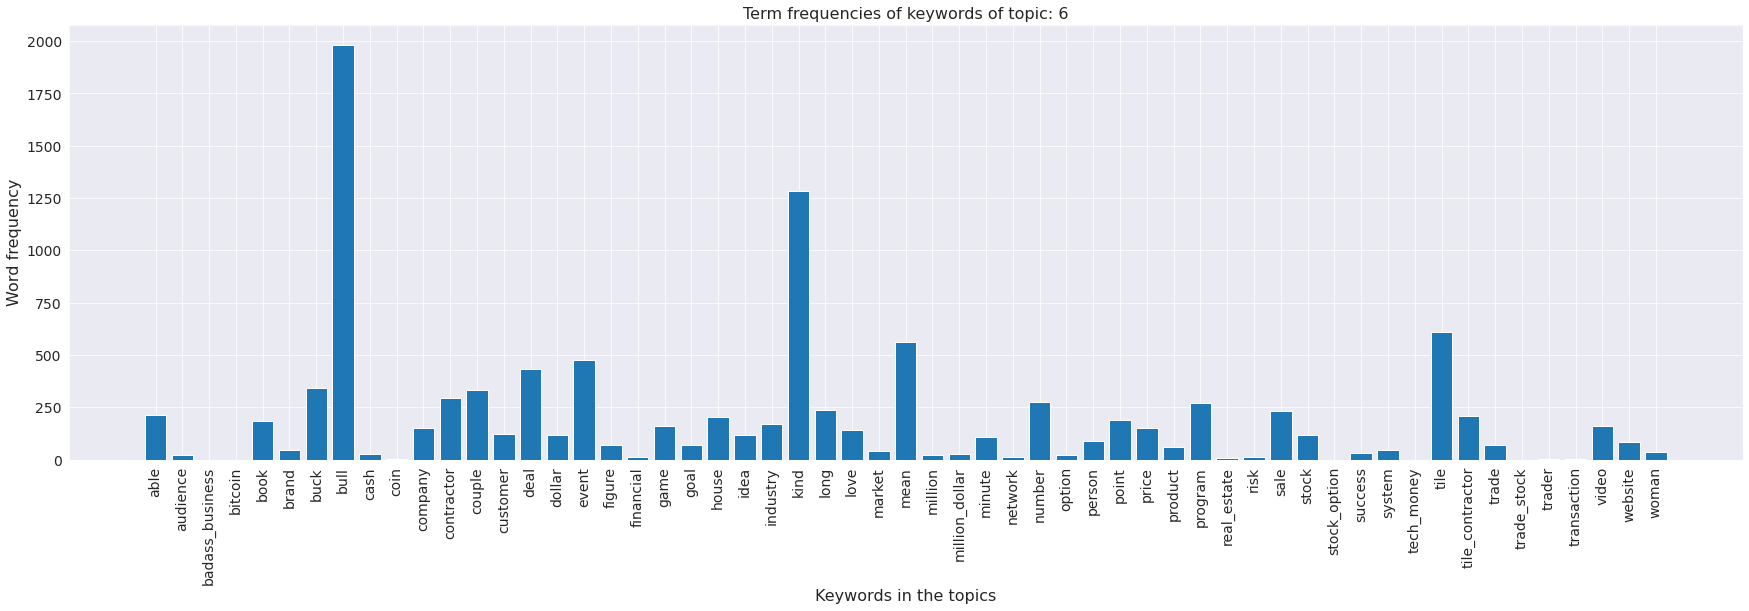

In [110]:
k=6
clusterwise_words_dist = lda_top_words_df.groupby('Cluster').get_group(k)
plt.figure(figsize=(30,8))
plt.bar(list(clusterwise_words_dist.sum()[:-1].transpose().index),\
        list(clusterwise_words_dist.sum()[:-1].transpose()))
plt.title(f'Term frequencies of keywords of topic: {k}',fontsize=16)
plt.xlabel('Keywords in the topics',fontsize=16)
plt.ylabel('Word frequency',fontsize=16)
plt.xticks(rotation=90,fontsize=14)
plt.yticks(fontsize=14);

In [111]:
word_totals = {k:{y[1]:y[0] for y in x[0]} for k,x in enumerate(top_topics)}

In [112]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from wordcloud import WordCloud

def show_wordcloud(topic=0):
    cloud = WordCloud(background_color='white', colormap='viridis')
    cloud.generate_from_frequencies(word_totals[topic])
    plt.gca().imshow(cloud)
    plt.axis('off')
    plt.tight_layout()
    
slider = IntSlider(min=0, max=best_hp_setting[0]-1, step=1, value=0, description='Topic')
interact(show_wordcloud, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=6), Output()), _dom_classes=('widget-interac…